In [1]:
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import scipy.optimize as scopt
from scipy.stats import gamma
from scipy.integrate import quad
from scipy.stats import chi2
import sympy as sym
from IPython.display import Image
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import LinearRegression

# Parameters for plots
params = {'text.usetex': True,
          'font.size': 14,
          'font.family': 'cmr10',
          'font.weight': 'bold',  # Add this line to make the text bolder
          #'axes.labelweight': '800'  # Make axis labels bold as well
          }

plt.rcParams.update(params)

# Functions for better labels

def span_string(your_string, max_char_one_line = 40):
    # given a string, this function divides it into sets of words smaller than max_char_one_line,
    # inserting a line break \n between them to span them over several lines. Returns one final string
    nn = max_char_one_line
    sum_len = 0
    word_index = 0
    if len(your_string) > nn:
        list_s = your_string.split()
        for k in list_s:
            word_index += 1
            sum_len += len(k)
            if sum_len >= nn:
                list_s.insert(word_index-1,'\n')
                sum_len = 0
        ret_str = ' '.join(list_s)
    else:
        ret_str = your_string
                
    return ret_str

def span_list_strings(list_strings, max_char_one_line = 40):
    # Applies span_string() to all elements of a list
    ret_list = []
    for l in list_strings:
        ret_list.append(span_string(l,max_char_one_line))
        
    return ret_list

# Custom normalization of an array, if needed
def normalizar(arr):
    a = np.array(arr)
    return a/1e6 #Divided by 1 million

# RMSE
def rmse(x,y,func,params):
    msee = np.sum(np.array(func(x,*params)) - np.array(y))**2/len(np.array(y))
    return np.sqrt(msee)

# Value of the Chi^2 probability
def chi2_table(chi_v,ndf):
    return 1-chi2.cdf(chi_v, ndf, loc=0, scale=1)

# Calculation of Chi^2
def chi2_calc(x_fit,x_true):
    errs = np.sqrt(np.abs(x_true))
    ch2 = ((x_true-x_fit)/errs)**2
    return np.sum(ch2)

# Normalization to 1, if needed
def nor_to_1(x):
    return x/np.max(abs(x))

Linear


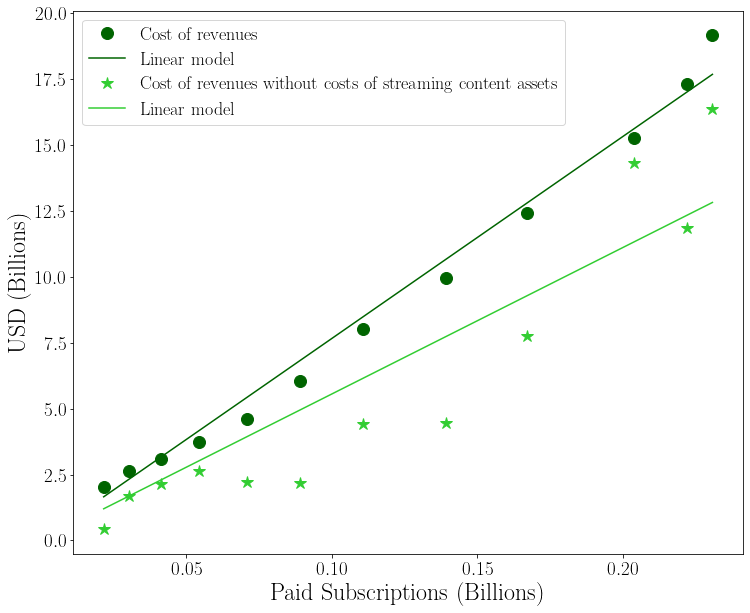

Power Law


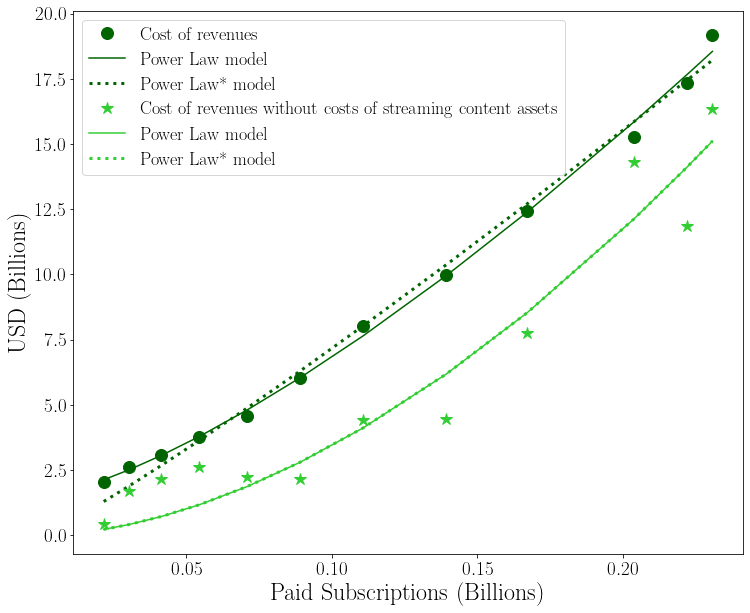

Exponential


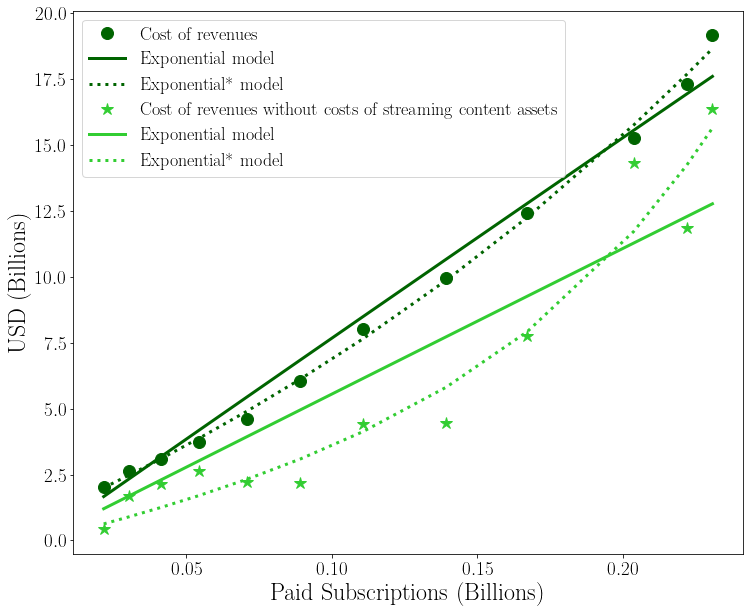

Logarithmic


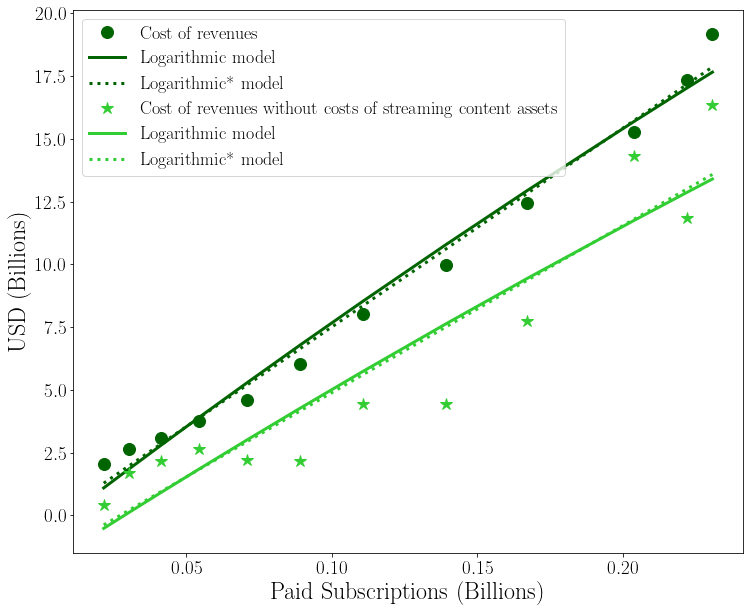

Linear


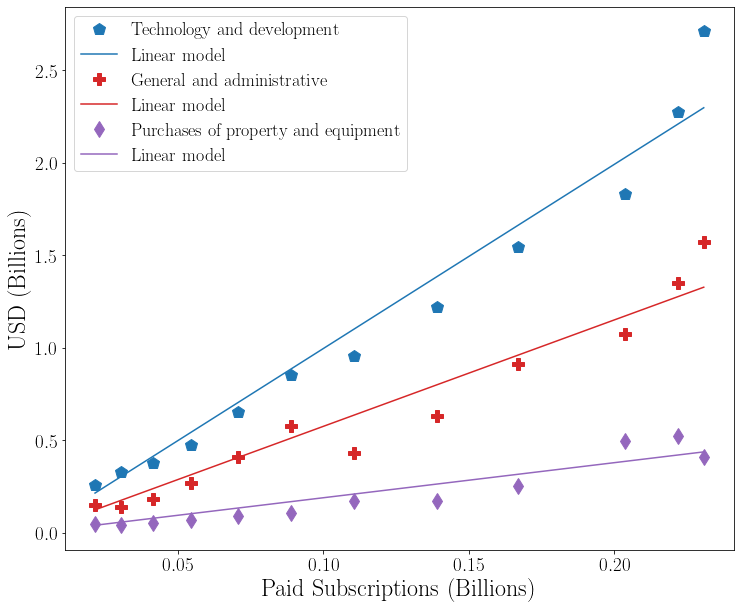

Power Law


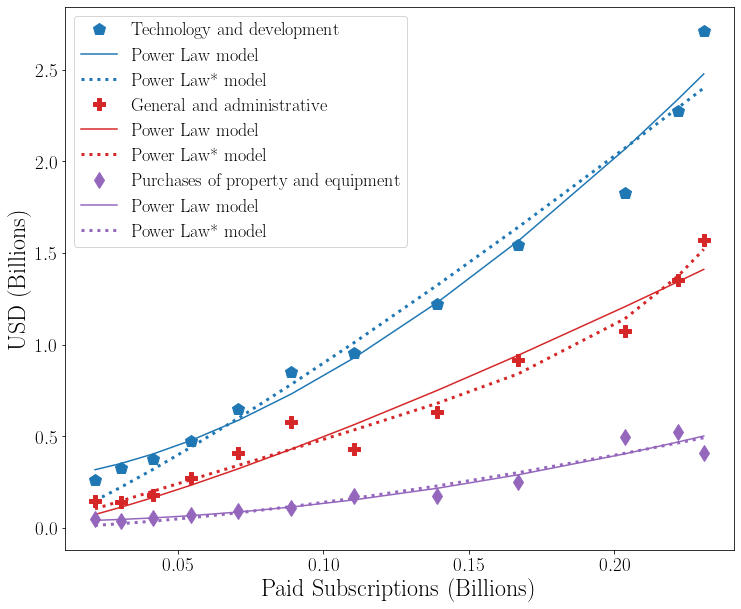

Exponential


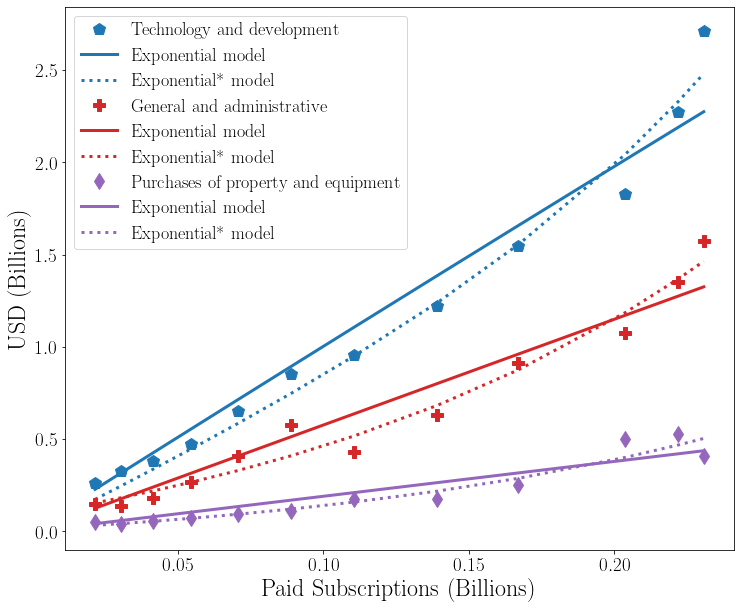

Logarithmic


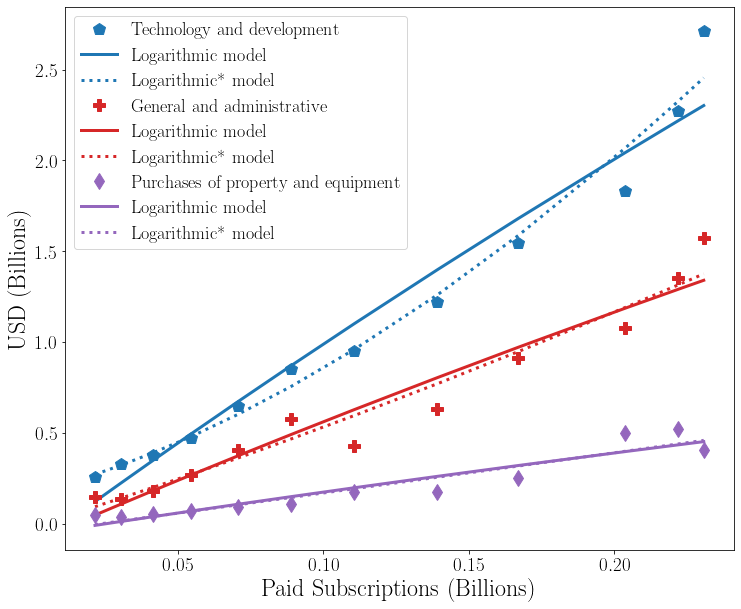

In [5]:
#Read Data
df_netflix = pd.read_csv('Netflix_data_all.csv')
    

# Data to fit: the "X" and the "Ys"
x = np.array(normalizar(df_netflix['Paid Subscriptions']))
cor = normalizar(df_netflix['Cost of revenues']) 
tnd = normalizar(df_netflix['Technology and development']) 
gna = normalizar(df_netflix['General and administrative']) 
ppe = normalizar(-df_netflix['Purchases of property and equipment']) 
cor_adit = normalizar(df_netflix['Cost of revenues']+df_netflix['Additions to streaming content assets'] + df_netflix['Amortization of streaming content assets'] ) 
ys_cors = [cor,cor_adit] # Costs of revenue and variations
ys_spec = [tnd,gna,ppe] # Specific Costs
ys_cors_labels= ['Cost of revenues','Cost of revenues without costs of streaming content assets']
ys_spec_labels= ['Technology and development',
            'General and administrative','Purchases of property and equipment']

colors_cors = ['darkgreen','limegreen']
colors_spec = ['tab:blue','tab:red','tab:purple']

# Zips for plotting different data and labels and colors
zipcors = list(zip(ys_cors,ys_cors_labels,colors_cors))
zipspec = list(zip(ys_spec,ys_spec_labels,colors_spec))

all_parameters = {
    'cf':[],
    'a':[],
    'b':[],
    'k':[],
    'alpha':[],
    'rmse':[],
    'model':[],
    'y_data':[],
    'EoS_DoS':[],
    'Chi2':[],
    'Chi2_prob':[]
}

colors_shapes = {
    'darkgreen':"o",
    'limegreen':'*',
    'tab:blue':'p',
    'tab:red':'P',
    'tab:purple':"d"
}


model_list = ['Linear','Power Law','Exponential','Logarithmic']
two_graphs = ['cors','spec']

for graph,zippp in zip(two_graphs,[zipcors,zipspec]):
    
    for model_choice in model_list:

        print(model_choice)

        plt.figure(figsize = [12,10])
        plt.xlabel('Paid Subscriptions (Billions)',size = 24)
        plt.ylabel('USD (Billions)',size = 24)
        plt.xticks(size = 19)
        plt.yticks(size = 19)
        #plt.title(model_choice + ' Model', fontsize = 28)

        for y,lab,clr in zippp:

            plt.plot(x,y,label = lab, marker=colors_shapes[clr], linestyle = '', markersize = 12, c = clr)


            ######################################
            ############ Linear Model ############
            ######################################

            if model_choice == 'Linear':

                def n_linear(N,cf,a):
                    return cf + a*N

                def opt_linear(params):
                    cf, a = params
                    N = x
                    return np.linalg.norm(cf + a*N - y)

                popt = scopt.minimize(opt_linear, [1,1], bounds = [(0,None),(None,None)]).x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(None)
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(None)
                all_parameters['rmse'].append(rmse(x,y,n_linear,popt))
                all_parameters['model'].append(model_choice)
                all_parameters['y_data'].append(lab)
                all_parameters['EoS_DoS'].append(None)
                all_parameters['Chi2'].append(chi2_calc(n_linear(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_linear(x,*popt),y),len(y)-len(popt)-1))



                #plt.plot(x,n_linear(x,*popt),label = '{} model;\n{}'.format(model_choice,lab), c=clr)
                plt.plot(x,n_linear(x,*popt),label = '{} model'.format(model_choice), c=clr)


            ######################################
            ############ Power  Model ############
            ######################################

            if model_choice == 'Power Law':

                ############# Pure Model #############
                def n_power(N,cf,a,b):
                    return cf + a*N**b 

                def opt_power(params):
                    cf,a,b = params
                    N = x
                    return np.linalg.norm(cf + a*N**b - y)


                #popt = scopt.minimize(opt_power, [0.3,0.1,0.1], bounds = [(0,None),(None,None),(-10,10)], 
                #                      method = 'Nelder-Mead').x
                
                popt = scopt.minimize(opt_power, [0.3,0.7,0.5], bounds = [(0,None),(None,None),(-10,10)], 
                                      method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(None)
                all_parameters['rmse'].append(rmse(x,y,n_power,popt))
                all_parameters['model'].append(model_choice)
                all_parameters['y_data'].append(lab)
                if popt[2] > 1:
                    all_parameters['EoS_DoS'].append('DoS')
                else:
                    all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_power(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_power(x,*popt),y),len(y)-len(popt)-1))

                #plt.plot(x,n_power(x,*popt),label = '{} model;\n{}'.format(model_choice,lab), c=clr)
                plt.plot(x,n_power(x,*popt),label = '{} model'.format(model_choice), c=clr)

                ############# Star (With Linear) Model #############
                def n_power(N,cf,a,b,alpha):
                    return cf + a*N**b + alpha*N

                def opt_power(params):
                    cf,a,b,alpha = params
                    N = x
                    return np.linalg.norm(cf + a*N**b + alpha*N - y)


                popt = scopt.minimize(opt_power, [0.1,1,0.1,0.1], bounds = [(0,None),(None,None),(-10,10),(0, None)],
                                     method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(popt[3])
                all_parameters['rmse'].append(rmse(x,y,n_power,popt))
                all_parameters['model'].append(model_choice + '*')
                all_parameters['y_data'].append(lab)
                if popt[2] > 1:
                    all_parameters['EoS_DoS'].append('DoS')
                else:
                    all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_power(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_power(x,*popt),y),len(y)-len(popt)-1))
                
                
                #plt.plot(x,n_power(x,*popt),label = '{}* model;\n{}'.format(model_choice,lab),
                #         c=clr, linestyle='dotted',linewidth = 3)
                plt.plot(x,n_power(x,*popt),label = '{}* model'.format(model_choice),
                         c=clr, linestyle='dotted',linewidth = 3)



            ######################################
            ######### Exponential Model ##########
            ######################################

            if model_choice == 'Exponential':

                ############# Pure Model #############
                def n_exp(N,cf,a,b):
                    return cf + a*(1-np.exp(-b*N)) 

                def opt_exp(params):
                    cf,a,b = params
                    N = x
                    return np.linalg.norm(cf + a*(1-np.exp(-b*N)) - y)


                popt = scopt.minimize(opt_exp, [0.1,1,1], bounds = [(0,None),(None,None),(None,None)],
                                     method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(None)
                all_parameters['rmse'].append(rmse(x,y,n_exp,popt))
                all_parameters['model'].append(model_choice)
                all_parameters['y_data'].append(lab)
                if popt[2] < 0:
                    all_parameters['EoS_DoS'].append('DoS')
                else:
                    all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_exp(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_exp(x,*popt),y),len(y)-len(popt)-1))

                #plt.plot(x,n_exp(x,*popt),label = '{} model;\n{}'.format(model_choice,lab),
                #         c=clr, linestyle='solid',linewidth = 3)
                plt.plot(x,n_exp(x,*popt),label = '{} model'.format(model_choice),
                         c=clr, linestyle='solid',linewidth = 3)

                ############# Star (With Linear) Model #############
                def n_exp(N,cf,a,b,alpha):
                    return cf + a*(1-np.exp(-b*N)) + alpha*N

                def opt_exp(params):
                    cf,a,b,alpha = params
                    N = x
                    return np.linalg.norm(cf + a*(1-np.exp(-b*N)) + alpha*N - y)


                popt = scopt.minimize(opt_exp, [0.1,0.1,0.1,0.1], bounds = [(0,None),(None,None),(None,None),(0, None)],
                                     method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(popt[3])
                all_parameters['rmse'].append(rmse(x,y,n_exp,popt))
                all_parameters['model'].append(model_choice + '*')
                all_parameters['y_data'].append(lab)
                if popt[2] < 0:
                    all_parameters['EoS_DoS'].append('DoS')
                else:
                    all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_exp(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_exp(x,*popt),y),len(y)-len(popt)-1))

                #plt.plot(x,n_exp(x,*popt),label = '{}* model;\n{}'.format(model_choice,lab),
                #         c=clr, linestyle='dotted',linewidth = 3)
                plt.plot(x,n_exp(x,*popt),label = '{}* model'.format(model_choice),
                         c=clr, linestyle='dotted',linewidth = 3)
                

            ######################################
            ######### Logarithmic Model ##########
            ######################################

            if model_choice == 'Logarithmic':

                ############# Pure Model #############
                def n_log(N,cf,a,b):
                    return cf + a*np.log(N+b)

                def opt_log(params):
                    cf,a,b = params
                    N = x
                    return np.linalg.norm(cf + a*np.log(N+b) - y)


                popt = scopt.minimize(opt_log, [0.1,1,10], bounds = [(0,None),(None,None),(0.01,None)],
                                     method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(None)
                all_parameters['rmse'].append(rmse(x,y,n_log,popt))
                all_parameters['model'].append(model_choice)
                all_parameters['y_data'].append(lab)
                all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_log(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_log(x,*popt),y),len(y)-len(popt)-1))

                #plt.plot(x,n_log(x,*popt),label = '{} model;\n{}'.format(model_choice,lab),
                #         c=clr, linestyle='solid',linewidth = 3)
                plt.plot(x,n_log(x,*popt),label = '{} model'.format(model_choice),
                         c=clr, linestyle='solid',linewidth = 3)

                ############# Star (With Linear) Model #############
                def n_log(N,cf,a,b,alpha):
                    return cf + a*np.log(N+b) + alpha*N

                def opt_log(params):
                    cf,a,b,alpha = params
                    N = x
                    return np.linalg.norm(cf + a*np.log(N+b) + alpha*N - y)


                popt = scopt.minimize(opt_log, [1,2,10,2], bounds = [(0,None),(None,None),(0.01,None),(0, None)],
                                     method = 'Nelder-Mead').x

                all_parameters['cf'].append(popt[0])
                all_parameters['a'].append(popt[1])
                all_parameters['b'].append(popt[2])
                all_parameters['k'].append(None)
                all_parameters['alpha'].append(popt[3])
                all_parameters['rmse'].append(rmse(x,y,n_log,popt))
                all_parameters['model'].append(model_choice + '*')
                all_parameters['y_data'].append(lab)
                all_parameters['EoS_DoS'].append('EoS')
                all_parameters['Chi2'].append(chi2_calc(n_log(x,*popt),y))
                all_parameters['Chi2_prob'].append(chi2_table(chi2_calc(n_log(x,*popt),y),len(y)-len(popt)-1))

                #plt.plot(x,n_log(x,*popt),label = '{}* model;\n{}'.format(model_choice,lab),
                #         c=clr, linestyle='dotted',linewidth = 3)
                plt.plot(x,n_log(x,*popt),label = '{}* model'.format(model_choice),
                         c=clr, linestyle='dotted',linewidth = 3)


        plt.legend(fontsize = 18)
        plt.show()

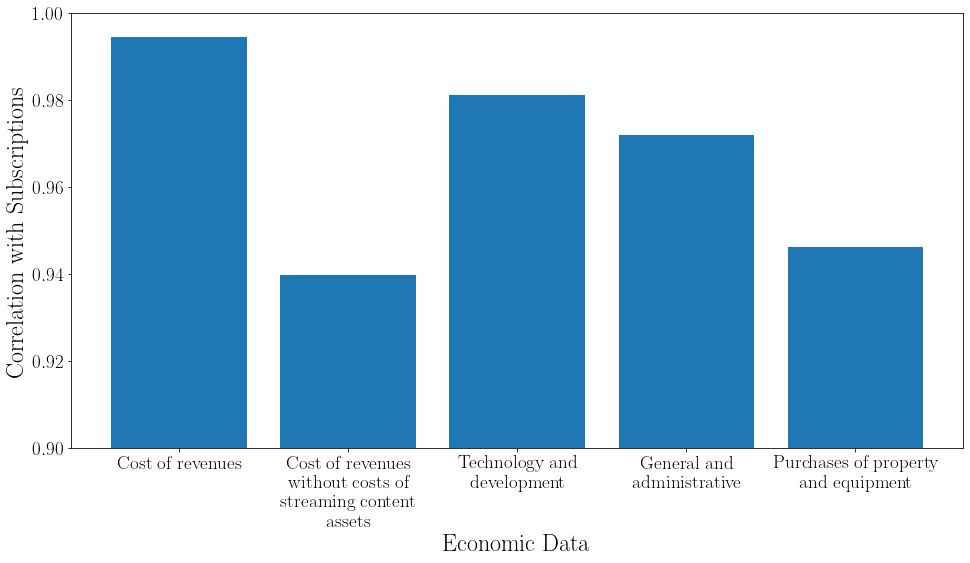

In [7]:
# Correlations

df_netflix = pd.read_csv('Netflix_data_all.csv')

c_labels= ['Cost of revenues','Cost of revenues without costs of streaming content assets','Technology and development',
            'General and administrative','Purchases of property and equipment']

corrs = df_netflix.corrwith(df_netflix['Paid Subscriptions'])[c_labels]

df_cors = pd.DataFrame({
    'Labels':span_list_strings(c_labels,20),
    'Correlations':abs(corrs)
})

#df_cors = df_cors.sort_values(by = ['Correlations'])

plt.figure(figsize = [16,8])
plt.xlabel('Economic Data',size = 24)
plt.ylabel('Correlation with Subscriptions',size = 24)
plt.xticks(size = 19)
plt.yticks(size = 19)
plt.ylim([.9,1])
plt.bar(df_cors['Labels'], df_cors['Correlations'])

plt.show()